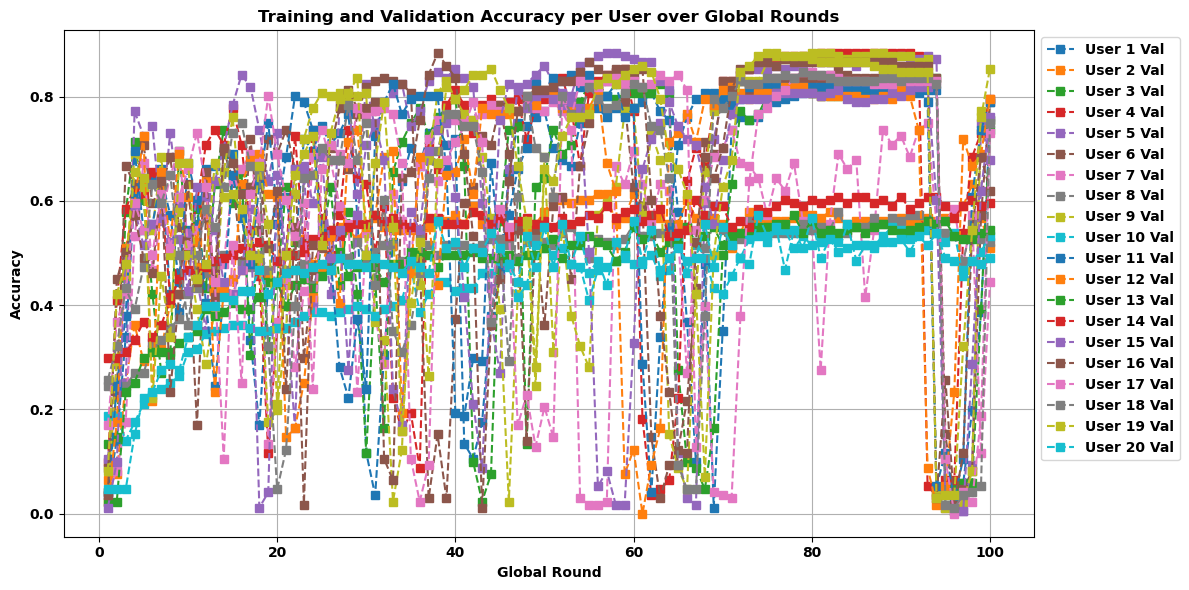

In [8]:
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Read the log file
file_path = "FMTLresults.txt"  # Change this to your actual file path
with open(file_path, "r") as f:
    logs = f.readlines()

# Initialize dictionaries to store extracted values
user_train_accuracies = defaultdict(list)
user_val_accuracies = defaultdict(list)
global_rounds = set()

# Regex patterns to match accuracy values
train_pattern = re.compile(r"Training model for User (\d+).*?Accuracy: ([0-9.]+)")
val_pattern = re.compile(r"User (\d+) - Validation Loss: [0-9.]+, Accuracy: ([0-9.]+)")
global_round_pattern = re.compile(r"Global Round (\d+)")

current_round = None

# Parse the log file
for line in logs:
    round_match = global_round_pattern.search(line)
    if round_match:
        current_round = int(round_match.group(1))
        global_rounds.add(current_round)
    
    train_match = train_pattern.search(line)
    if train_match and current_round is not None:
        user_id = int(train_match.group(1))
        accuracy = float(train_match.group(2))
        user_train_accuracies[user_id].append((current_round, accuracy))
    
    val_match = val_pattern.search(line)
    if val_match and current_round is not None:
        user_id = int(val_match.group(1))
        accuracy = float(val_match.group(2))
        user_val_accuracies[user_id].append((current_round, accuracy))


# Plot the results for each user
plt.figure(figsize=(12, 6))
for user_id, acc_list in user_train_accuracies.items():
    rounds, acc = zip(*sorted(acc_list))
    plt.plot(rounds, acc, marker="o", label=f"User {user_id} Train")
    
for user_id, acc_list in user_val_accuracies.items():
    rounds, acc = zip(*sorted(acc_list))
    plt.plot(rounds, acc, marker="s", linestyle="--", label=f"User {user_id} Val")

plt.xlabel("Global Round")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per User over Global Rounds")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
user_train_accuracies

defaultdict(list, {})

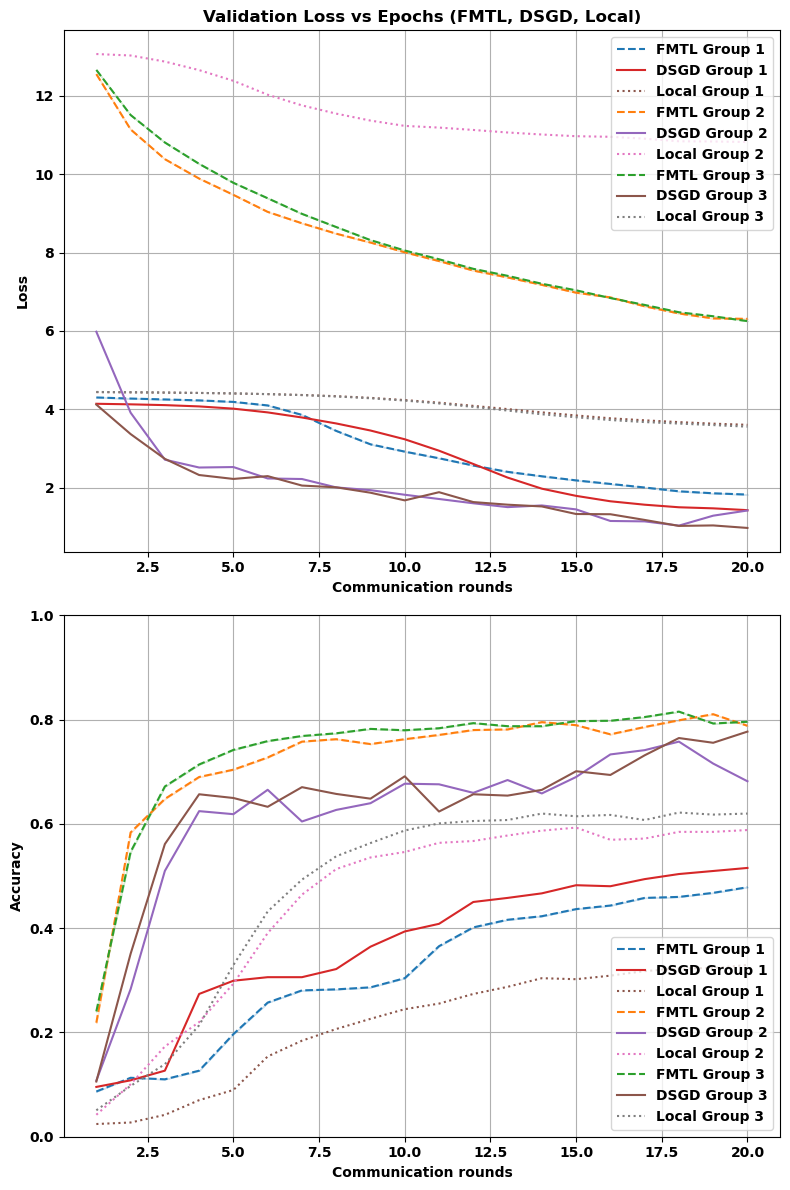

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Define metrics directory and file paths
metrics_directory = "./"
fmtl_metrics_file = f'{metrics_directory}FMTL_metrics_randn_P_adam.json'
dsgd_metrics_file = f'{metrics_directory}DSGD_results_adam.json'
local_metrics_file = f'{metrics_directory}local_drone.json'

# Load the metrics from JSON files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

fmtl_metrics = load_json(fmtl_metrics_file)
dsgd_metrics = load_json(dsgd_metrics_file)
local_metrics = load_json(local_metrics_file)

# Convert metrics to numpy arrays
fmtl_group_train_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_train_loss_mean'].items()}
fmtl_group_val_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_mean'].items()}
fmtl_group_val_accuracy_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_mean'].items()}

# Standard deviations
fmtl_group_train_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_train_loss_std'].items()}
fmtl_group_val_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_std'].items()}
fmtl_group_val_acc_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_std'].items()}

# Load DSGD and Local metrics
dsgd_group_val_loss_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_loss_mean'].items()}
dsgd_group_val_accuracy_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_mean'].items()}
local_group_val_loss_histories = {k: np.array(v) for k, v in local_metrics['group_val_loss_mean'].items()}
local_group_val_accuracy_histories = {k: np.array(v) for k, v in local_metrics['group_val_acc_mean'].items()}

# Plot results
plt.figure(figsize=(8, 12))

# Validation Loss Plot
plt.subplot(2, 1, 1)
for group in fmtl_group_val_loss_histories.keys():
    epochs = range(1, len(fmtl_group_val_loss_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_loss_histories[group], label=f"FMTL Group {group}", linestyle="dashed", color=f'C{int(group)-1}')
    plt.fill_between(epochs, 
                     fmtl_group_val_loss_histories[group] - fmtl_group_val_loss_std[group], 
                     fmtl_group_val_loss_histories[group] + fmtl_group_val_loss_std[group], 
                     alpha=0.2, color=f'C{int(group)-1}')
    
    plt.plot(epochs, dsgd_group_val_loss_histories[group], label=f"DSGD Group {group}", linestyle="solid", color=f'C{int(group)+2}')
    plt.plot(epochs, local_group_val_loss_histories[group][:20], label=f"Local Group {group}", linestyle="dotted", color=f'C{int(group)+4}')
    
plt.title("Validation Loss vs Epochs (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid()

# Validation Accuracy Plot
plt.subplot(2, 1, 2)
for group in fmtl_group_val_accuracy_histories.keys():
    epochs = range(1, len(fmtl_group_val_accuracy_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_accuracy_histories[group], label=f"FMTL Group {group}", linestyle="dashed", color=f'C{int(group)-1}')
    plt.fill_between(epochs, 
                     fmtl_group_val_accuracy_histories[group] - fmtl_group_val_acc_std[group], 
                     fmtl_group_val_accuracy_histories[group] + fmtl_group_val_acc_std[group], 
                     alpha=0.2, color=f'C{int(group)-1}')
    
    plt.plot(epochs, dsgd_group_val_accuracy_histories[group], label=f"DSGD Group {group}", linestyle="solid", color=f'C{int(group)+2}')
    plt.plot(epochs, local_group_val_accuracy_histories[group][:20], label=f"Local Group {group}", linestyle="dotted", color=f'C{int(group)+4}')
    
#plt.title("Validation Accuracy vs Communication Rounds (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Accuracy should be between 0 and 1
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()

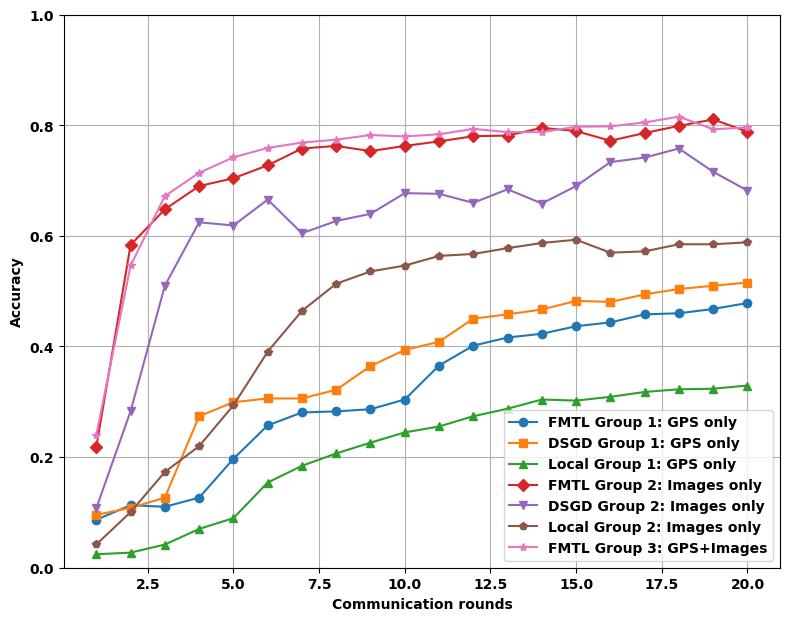

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Define metrics directory and file paths
metrics_directory = "./"
fmtl_metrics_file = f'{metrics_directory}FMTL_metrics_randn_P_adam.json'
dsgd_metrics_file = f'{metrics_directory}DSGD_results_adam.json'
local_metrics_file = f'{metrics_directory}local_drone.json'

# Load the metrics from JSON files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

fmtl_metrics = load_json(fmtl_metrics_file)
dsgd_metrics = load_json(dsgd_metrics_file)
local_metrics = load_json(local_metrics_file)

# Convert metrics to numpy arrays
fmtl_group_val_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_mean'].items()}
fmtl_group_val_accuracy_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_mean'].items()}

# Standard deviations
fmtl_group_val_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_std'].items()}
fmtl_group_val_acc_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_std'].items()}

# Load DSGD and Local metrics
dsgd_group_val_loss_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_loss_mean'].items() if k != '3'}
dsgd_group_val_accuracy_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_mean'].items() if k != '3'}
local_group_val_loss_histories = {k: np.array(v) for k, v in local_metrics['group_val_loss_mean'].items() if k != '3'}
local_group_val_accuracy_histories = {k: np.array(v) for k, v in local_metrics['group_val_acc_mean'].items() if k != '3'}

# Rename groups
group_names = {'1': 'Group 1: GPS only', '2': 'Group 2: Images only', '3': 'Group 3: GPS+Images'}


markers = ['o', 's', '^', 'D', 'v', 'p', '*']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']  # Blue, Orange, Green, Red, Purple, Brown, Pink


# Plot results
plt.figure(figsize=(8, 12))
'''
# Validation Loss Plot
plt.subplot(2, 1, 1)
i = 0
for group in fmtl_group_val_loss_histories.keys():
    
    epochs = range(1, len(fmtl_group_val_loss_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_loss_histories[group], label=f"FMTL {group_names[group]}", marker=markers[i], color=colors[i])
    i = i + 1
    
    if group in dsgd_group_val_loss_histories:
        plt.plot(epochs, dsgd_group_val_loss_histories[group], label=f"DSGD {group_names[group]}", marker=markers[i], color=colors[i])  # Red
        i = i + 1
    if group in local_group_val_loss_histories:
        plt.plot(epochs, local_group_val_loss_histories[group], label=f"Local {group_names[group]}", marker=markers[i], color=colors[i])  # Purple
        i = i + 1
plt.title("Validation Loss vs Communication Rounds (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid()
'''
i = 0

# Validation Accuracy Plot
plt.subplot(2, 1, 2)
for group in fmtl_group_val_accuracy_histories.keys():
    epochs = range(1, len(fmtl_group_val_accuracy_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_accuracy_histories[group], label=f"FMTL {group_names[group]}", marker=markers[i], color=colors[i])
    i = i + 1
    if group in dsgd_group_val_accuracy_histories:
        plt.plot(epochs, dsgd_group_val_accuracy_histories[group], label=f"DSGD {group_names[group]}", marker=markers[i], color=colors[i])  # Red
        i = i + 1
    if group in local_group_val_accuracy_histories:
        plt.plot(epochs, local_group_val_accuracy_histories[group], label=f"Local {group_names[group]}", marker=markers[i], color=colors[i])  # Purple
        i = i + 1
    
plt.xlabel("Communication rounds")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Accuracy should be between 0 and 1
plt.legend(loc='lower right')
plt.grid()
plt.savefig('Acuracy_drone_iid_full_images.pdf')

plt.tight_layout()
plt.show()